In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import pathlib
import matplotlib.pyplot as plt

from glob import glob
import os 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Activation
# from keras.callbacks import EarlyStopping
# from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Activation

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import InputLayer

## Check & Load Data from Directory

In [ ]:
dir = 'drive/MyDrive/DL/dataset_images' 

In [ ]:
data_dir = pathlib.Path("drive/MyDrive/DL/dataset_images")

In [ ]:
image_count = len(list(data_dir.glob('**/*.png')))
print(image_count)

4119


In [ ]:
df = pd.read_csv("drive/MyDrive/DL/path_prob.csv")

In [ ]:
df.head(3)

,Unnamed: 0,ID,emotion,path
0,0,58c6237dedc2c9c7dc0de1ae,happiness,dataset_images/58c6237dedc2c9c7dc0de1ae.png
1,1,577280dfedc2cb3880f28e76,anticipation,dataset_images/577280dfedc2cb3880f28e76.png
2,2,57727f2dedc2cb3880ed5fa9,happiness,dataset_images/57727f2dedc2cb3880ed5fa9.png


In [ ]:
df.path = "drive/MyDrive/DL/" + df.path
df

In [ ]:
df.emotion.value_counts()

happiness           1102
surprise             822
anticipation         520
trust                478
fear                 358
sadness              226
humility             184
love                 114
disgust              101
optimism              62
arrogance             52
anger                 36
gratitude             14
pessimism             10
disagreeableness       7
shame                  7
agreeableness          5
neutral                5
shyness                2
Name: emotion, dtype: int64

In [ ]:
frequent_emotions = ["happiness", 'surprise', 'anticipation', 'trust', 'fear', 'sadness', \
                     'humility', 'love', 'disgust', 'optimism']

In [ ]:
df = df[(df.emotion == "happiness") | (df.emotion == "surprise")| (df.emotion == "anticipation")| (df.emotion == "trust")\
   | (df.emotion == "fear")| (df.emotion == "sadness")| (df.emotion == "humility")| (df.emotion == "love")\
   | (df.emotion == "disgust")| (df.emotion == "optimism")]

## Modeling 

We will first set the parameters that we will be using throughout the modeling process and then run the following models: 
1. Baseline 
2. Using Convolutions
3. Data Augmentation (with the Convolutions) 
4. A second way of Data Augmentation (implemented with Convolutions) 
5. Transfer Learning 
6. Transfer Learning with Data Augmentation 
7. Transfer Learning with Data Augmentation Getting Rid of Dense Layers but adding more Dropouts as well as regularization in the Layers
8. Another similar model 
9. Try VGG16 architecture 
10. VGG16 with CNN's on top 

### Set parameters

Let's set some of the parameters we will be using. 

- The image size we will resize all images to at the beginning of our training process. 
- We will set the number of epochs to a certain number so that we can keep tweaking it later. 
- Batch size will be 32. 
- The emotions we will be working with. 
- We will split the data into 3: train - validation - test (60% - 20% - 20%) 

In [ ]:
img_height = 180
img_width = 180

In [ ]:
epochs = 100
batch_size = 32

In [ ]:
val_set_start = int((7.5)*image_count//10)
test_set_start = int(9*image_count//10)

In [ ]:
test_set_start

3707

In [ ]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "categorical",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            # # interpolation = 'bilinear',
                                            # seed = 42,
                                            shuffle = False,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

Found 3089 validated image filenames belonging to 10 classes.
Found 618 validated image filenames belonging to 10 classes.
Found 260 validated image filenames belonging to 10 classes.


In [ ]:
class_names = train_generator.class_indices
print(class_names)

{'anticipation': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'humility': 4, 'love': 5, 'optimism': 6, 'sadness': 7, 'surprise': 8, 'trust': 9}


In [ ]:
images, labels = next(train_generator)
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 180, 180, 3)
float32 (32, 10)


In [ ]:
num_classes = len(class_names)
num_classes

10

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size


### 1. Baseline

We will make three generators according to the above split. 

The number of classes will be the number of emotions examined. We know from our EDA that there is a class imbalance between the classses but as we are doing multi-labels we will go with this for now. 

We will then make a baseline model with 20 nodes and plot to see how train & validation accuracy and losses change over epochs. 

In [ ]:
model = Sequential([
    keras.layers.InputLayer(input_shape=(img_height, img_width,3)),
    keras.layers.Dense(units = 20, activation = 'relu'), 
    keras.layers.Flatten(),
    keras.layers.Dense(units = num_classes, activation = 'softmax') 
])

In [ ]:
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 180, 180, 20)      80        
                                                                 
 flatten_8 (Flatten)         (None, 648000)            0         
                                                                 
 dense_18 (Dense)            (None, 10)                6480010   
                                                                 
Total params: 6,480,090
Trainable params: 6,480,090
Non-trainable params: 0
_________________________________________________________________


We will use Early Stopping because we know from earlier tries that this model does overfit. 

In [ ]:
history_baseline = model.fit(train_generator,
                    # steps_per_epoch=STEP_SIZE_TRAIN,
                    steps_per_epoch = 25, 
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 8,\
                                             restore_best_weights=True)
)

Epoch 1/100
25/25 [==============================] - 304s 12s/step - loss: 61.2937 - accuracy: 0.1988 - val_loss: 25.7853 - val_accuracy: 0.2747
Epoch 2/100
25/25 [==============================] - 74s 3s/step - loss: 14.6898 - accuracy: 0.2300 - val_loss: 11.1056 - val_accuracy: 0.2681
Epoch 3/100
25/25 [==============================] - 62s 3s/step - loss: 7.2762 - accuracy: 0.2587 - val_loss: 7.5236 - val_accuracy: 0.3059
Epoch 4/100
25/25 [==============================] - 58s 2s/step - loss: 5.8525 - accuracy: 0.2788 - val_loss: 7.1661 - val_accuracy: 0.1859
Epoch 5/100
25/25 [==============================] - 50s 2s/step - loss: 6.0651 - accuracy: 0.3363 - val_loss: 4.9380 - val_accuracy: 0.2533
Epoch 6/100
25/25 [==============================] - 45s 2s/step - loss: 3.7749 - accuracy: 0.3450 - val_loss: 4.9282 - val_accuracy: 0.1645
Epoch 7/100
25/25 [==============================] - 44s 2s/step - loss: 5.8472 - accuracy: 0.3338 - val_loss: 4.8048 - val_accuracy: 0.1974
Epoch 8

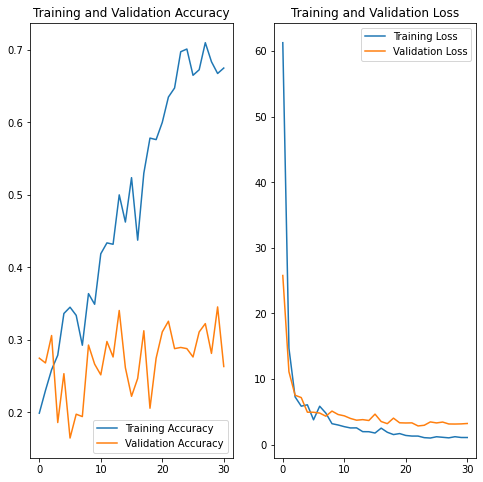

In [ ]:
number_of_epochs_it_ran = len(history_baseline.history['loss'])

acc = history_baseline.history['accuracy']
val_acc = history_baseline.history['val_accuracy']

loss = history_baseline.history['loss']
val_loss = history_baseline.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 2. Using Convolutions

Let's first try making our own convolutions. 

In [ ]:
model = Sequential()


model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 180, 180, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 178, 178, 32)      9248      
_________________________________________________________________
activation_6 (Activation)    (None, 178, 178, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 89, 89, 64)       

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
history_cnn = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 20,\
                                             restore_best_weights=True)
)

Epoch 1/100
77/77 [==============================] - 355s 5s/step - loss: 0.2314 - accuracy: 0.1517 - val_loss: 0.1930 - val_accuracy: 0.1900
Epoch 2/100
77/77 [==============================] - 361s 5s/step - loss: 0.1765 - accuracy: 0.1825 - val_loss: 0.1949 - val_accuracy: 0.1912
Epoch 3/100
77/77 [==============================] - 345s 4s/step - loss: 0.1709 - accuracy: 0.2046 - val_loss: 0.1852 - val_accuracy: 0.2250
Epoch 4/100
77/77 [==============================] - 357s 5s/step - loss: 0.1698 - accuracy: 0.2165 - val_loss: 0.1815 - val_accuracy: 0.2150
Epoch 5/100
77/77 [==============================] - 353s 5s/step - loss: 0.1643 - accuracy: 0.2288 - val_loss: 0.1819 - val_accuracy: 0.2150
Epoch 6/100
77/77 [==============================] - 349s 5s/step - loss: 0.1601 - accuracy: 0.2382 - val_loss: 0.1805 - val_accuracy: 0.2075
Epoch 7/100
77/77 [==============================] - 295s 4s/step - loss: 0.1515 - accuracy: 0.2542 - val_loss: 0.1885 - val_accuracy: 0.2200
Epoch 

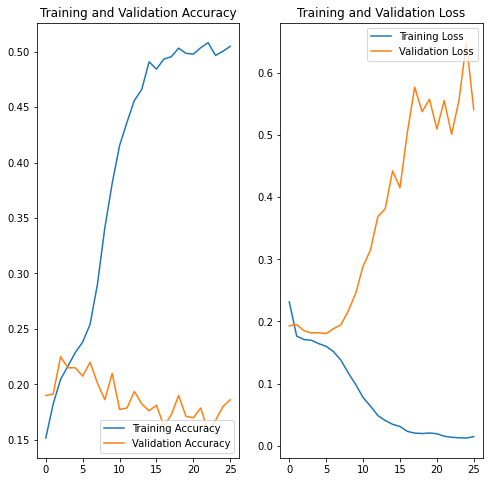

In [ ]:
number_of_epochs_it_ran = len(history_cnn.history['loss'])

acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3. Data Augmentation

Now let's try the same convolutions we looked at but do it with augmented data. 

In [ ]:
train_generator.reset()
valid_generator.reset()
test_generator.reset()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
model = Sequential([
    data_augmentation, 
    layers.Conv2D(32, (3, 3), padding='same', activation = 'relu'), 
    layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'), 
    layers.MaxPooling2D(pool_size=(2, 2)), 
    layers.Dropout(0.25), 
    layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'), 
    layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'), 
    layers.MaxPooling2D(pool_size=(2, 2)), 
    layers.Dropout(0.25), 
    layers.Flatten(),
    layers.Dense(512, activation = 'relu'), 
    layers.Dropout(0.5), 
    layers.Dense(num_classes, activation='softmax')])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 64)        36928     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 90, 90, 64)       

In [ ]:
history_aug = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 20,\
                                             restore_best_weights=True)
)

Epoch 1/100
77/77 [==============================] - 666s 9s/step - loss: 0.2000 - accuracy: 0.1636 - val_loss: 0.1952 - val_accuracy: 0.2225
Epoch 2/100
77/77 [==============================] - 453s 6s/step - loss: 0.1746 - accuracy: 0.1866 - val_loss: 0.1797 - val_accuracy: 0.2275
Epoch 3/100
77/77 [==============================] - 449s 6s/step - loss: 0.1718 - accuracy: 0.2013 - val_loss: 0.1840 - val_accuracy: 0.1887
Epoch 4/100
77/77 [==============================] - 513s 7s/step - loss: 0.1681 - accuracy: 0.2083 - val_loss: 0.1773 - val_accuracy: 0.2013
Epoch 5/100
77/77 [==============================] - 495s 6s/step - loss: 0.1689 - accuracy: 0.2050 - val_loss: 0.1803 - val_accuracy: 0.2250
Epoch 6/100
77/77 [==============================] - 476s 6s/step - loss: 0.1674 - accuracy: 0.2103 - val_loss: 0.1783 - val_accuracy: 0.2175
Epoch 7/100
77/77 [==============================] - 439s 6s/step - loss: 0.1671 - accuracy: 0.2103 - val_loss: 0.1767 - val_accuracy: 0.2212
Epoch 

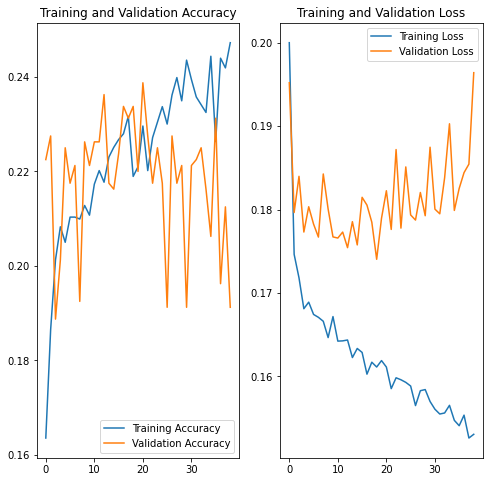

In [ ]:
number_of_epochs_it_ran = len(history_aug.history['loss'])

acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']

loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4. Second Way: Data Augmentation

A second way of data augmentation. Data augmentation is important as we are overfitting badly so we have to figure out ways to deal with this. 

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "categorical",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = emotions,
                                            batch_size = 32,
                                            interpolation = 'bilinear',    
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

Found 2471 validated image filenames.
Found 824 validated image filenames.
Found 810 validated image filenames.


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
activation_10 (Activation)   (None, 180, 180, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 178, 178, 32)      9248      
_________________________________________________________________
activation_11 (Activation)   (None, 178, 178, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 89, 89, 64)       

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
history_aug2 = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs, 
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 8,\
                                             restore_best_weights=True)

)

Epoch 1/100
77/77 [==============================] - 383s 5s/step - loss: 0.2078 - accuracy: 0.1574 - val_loss: 0.1845 - val_accuracy: 0.2138
Epoch 2/100
77/77 [==============================] - 376s 5s/step - loss: 0.1751 - accuracy: 0.1895 - val_loss: 0.1820 - val_accuracy: 0.2175
Epoch 3/100
77/77 [==============================] - 398s 5s/step - loss: 0.1743 - accuracy: 0.1948 - val_loss: 0.1807 - val_accuracy: 0.2188
Epoch 4/100
77/77 [==============================] - 379s 5s/step - loss: 0.1700 - accuracy: 0.2017 - val_loss: 0.1791 - val_accuracy: 0.2237
Epoch 5/100
77/77 [==============================] - 396s 5s/step - loss: 0.1702 - accuracy: 0.1972 - val_loss: 0.1798 - val_accuracy: 0.2200
Epoch 6/100
77/77 [==============================] - 391s 5s/step - loss: 0.1704 - accuracy: 0.2021 - val_loss: 0.1807 - val_accuracy: 0.2000
Epoch 7/100
77/77 [==============================] - 449s 6s/step - loss: 0.1679 - accuracy: 0.2066 - val_loss: 0.1799 - val_accuracy: 0.2125
Epoch 

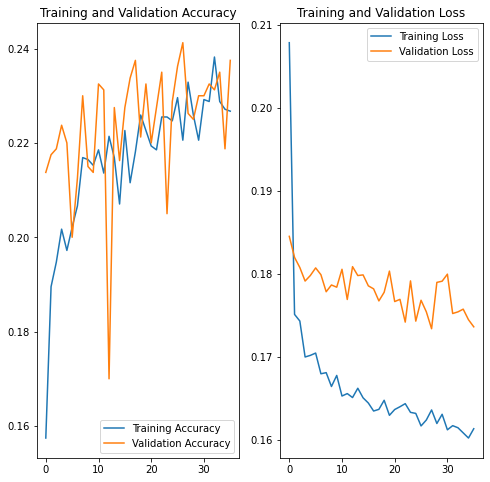

In [ ]:
number_of_epochs_it_ran = len(history_aug2.history['loss'])

acc = history_aug2.history['accuracy']
val_acc = history_aug2.history['val_accuracy']

loss = history_aug2.history['loss']
val_loss = history_aug2.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 5. Transfer Learning

OK maybe our own convolutions are not working for us. Let's borrow from the giants. \
MobileNetV2 is what we will resort to first. 

In [ ]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "categorical",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

Found 2471 validated image filenames.
Found 824 validated image filenames.
Found 810 validated image filenames.


In [ ]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   


In [ ]:
x = base_model.output
x = Flatten()(x) 
x = Dense(512, activation='relu')(x) 
x = Dense(50, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 90, 90, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
history_transfer = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 8,\
                                             restore_best_weights=True)
)

Epoch 1/100
77/77 [==============================] - 170s 2s/step - loss: 0.8022 - accuracy: 0.1464 - val_loss: 0.4344 - val_accuracy: 0.2237
Epoch 2/100
77/77 [==============================] - 125s 2s/step - loss: 0.1652 - accuracy: 0.3374 - val_loss: 0.3307 - val_accuracy: 0.2500
Epoch 3/100
77/77 [==============================] - 137s 2s/step - loss: 0.0974 - accuracy: 0.4207 - val_loss: 0.3221 - val_accuracy: 0.2163
Epoch 4/100
77/77 [==============================] - 151s 2s/step - loss: 0.0620 - accuracy: 0.4637 - val_loss: 0.3378 - val_accuracy: 0.2488
Epoch 5/100
77/77 [==============================] - 132s 2s/step - loss: 0.0530 - accuracy: 0.4777 - val_loss: 0.4128 - val_accuracy: 0.2387
Epoch 6/100
77/77 [==============================] - 127s 2s/step - loss: 0.0396 - accuracy: 0.4867 - val_loss: 0.4066 - val_accuracy: 0.2587
Epoch 7/100
77/77 [==============================] - 122s 2s/step - loss: 0.0332 - accuracy: 0.4883 - val_loss: 0.4377 - val_accuracy: 0.2387
Epoch 

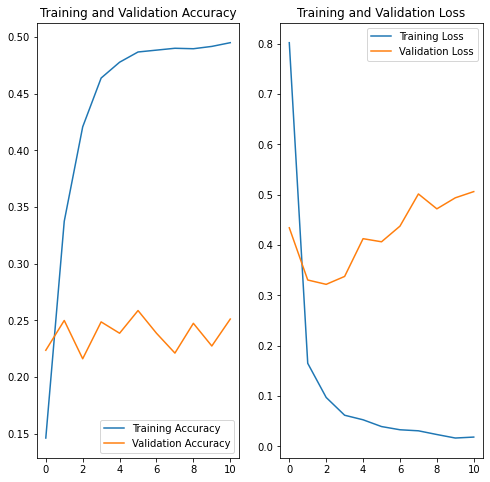

In [ ]:
number_of_epochs_it_ran = len(history_transfer.history['loss'])

acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']

loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Still overfitting out of this world. 

### 6. Transfer Learning with Data Augmentation

OK, one more resort: try transfer with augmented data. 

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "categorical",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

Found 2471 validated image filenames.
Found 824 validated image filenames.
Found 810 validated image filenames.


In [ ]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   


In [ ]:
# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(512, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(50, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 90, 90, 32)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
history_transfer_aug = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 8,\
                                             restore_best_weights=True)
)

Epoch 1/100
77/77 [==============================] - 180s 2s/step - loss: 0.1842 - accuracy: 0.2645 - val_loss: 0.2474 - val_accuracy: 0.2125
Epoch 2/100
77/77 [==============================] - 167s 2s/step - loss: 0.1822 - accuracy: 0.2739 - val_loss: 0.2440 - val_accuracy: 0.1688
Epoch 3/100
77/77 [==============================] - 155s 2s/step - loss: 0.1741 - accuracy: 0.2702 - val_loss: 0.2521 - val_accuracy: 0.2525
Epoch 4/100
77/77 [==============================] - 154s 2s/step - loss: 0.1674 - accuracy: 0.2759 - val_loss: 0.2183 - val_accuracy: 0.2400
Epoch 5/100
77/77 [==============================] - 169s 2s/step - loss: 0.1582 - accuracy: 0.2845 - val_loss: 0.2332 - val_accuracy: 0.2450
Epoch 6/100
77/77 [==============================] - 169s 2s/step - loss: 0.1471 - accuracy: 0.3001 - val_loss: 0.2552 - val_accuracy: 0.2212
Epoch 7/100
77/77 [==============================] - 169s 2s/step - loss: 0.1676 - accuracy: 0.2854 - val_loss: 0.2283 - val_accuracy: 0.2275
Epoch 

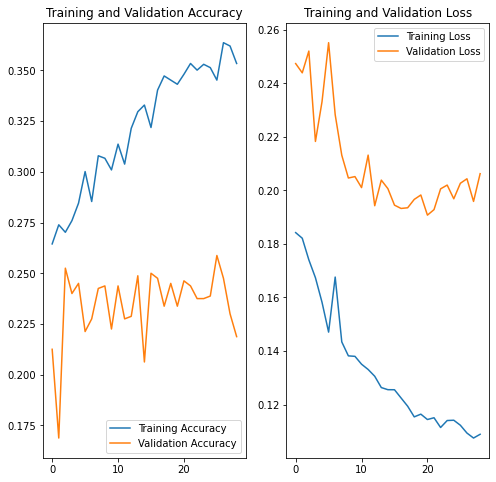

In [ ]:
number_of_epochs_it_ran = len(history_transfer_aug.history['loss'])

acc = history_transfer_aug.history['accuracy']
val_acc = history_transfer_aug.history['val_accuracy']

loss = history_transfer_aug.history['loss']
val_loss = history_transfer_aug.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 7. Transfer Learning + Data Augmentation + Less Complex with more Dropouts + Regularization

Make it less complex and try more dropouts. 

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "categorical",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

Found 2471 validated image filenames.
Found 824 validated image filenames.
Found 810 validated image filenames.


In [ ]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(224, 224,3)) 

for layer in base_model.layers:
    layer.trainable = False   


In [ ]:
L2 = 50
DROP = 0.3

x = base_model.output
x = Flatten()(x) 
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x) 
x = Dropout(DROP)(x)
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
predictions = Dense(num_classes, activation='softmax')(x) 


model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#NOT TRYING THIS OUT NOW BUT NEXT STEP WILL BE SETTING LR EVEN SMALLER
#model.compile(keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 90, 90, 32)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
lr = (ReduceLROnPlateau(factor=.5, patience=3, verbose=1))
es = (EarlyStopping(verbose=1, patience = 8, restore_best_weights=True))

history_transfer_aug_drop = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = [es, lr]
)


# TAKING OUT THE FOLLOWING FROM LAST MODEL IN EARLYSTOPPING: 
# monitor='val_loss', mode='min', 

Epoch 1/100
77/77 [==============================] - 189s 2s/step - loss: 1842.3829 - accuracy: 0.0631 - val_loss: 904.1088 - val_accuracy: 0.0800
Epoch 2/100
77/77 [==============================] - 238s 3s/step - loss: 546.9948 - accuracy: 0.0759 - val_loss: 290.3292 - val_accuracy: 0.0712
Epoch 3/100
77/77 [==============================] - 161s 2s/step - loss: 167.3066 - accuracy: 0.1160 - val_loss: 81.5354 - val_accuracy: 0.2113
Epoch 4/100
77/77 [==============================] - 161s 2s/step - loss: 44.5606 - accuracy: 0.1492 - val_loss: 19.7640 - val_accuracy: 0.2087
Epoch 5/100
77/77 [==============================] - 151s 2s/step - loss: 10.2692 - accuracy: 0.1849 - val_loss: 4.1903 - val_accuracy: 0.2075
Epoch 6/100
77/77 [==============================] - 147s 2s/step - loss: 2.1027 - accuracy: 0.1956 - val_loss: 0.8807 - val_accuracy: 0.2150
Epoch 7/100
77/77 [==============================] - 147s 2s/step - loss: 0.4938 - accuracy: 0.2071 - val_loss: 0.2888 - val_accuracy

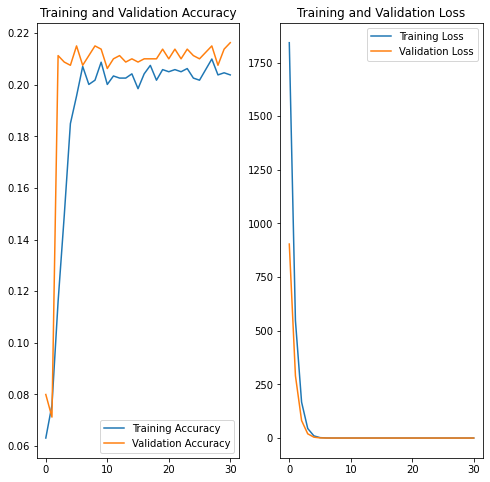

In [ ]:
number_of_epochs_it_ran = len(history_transfer_aug_drop.history['loss'])

acc = history_transfer_aug_drop.history['accuracy']
val_acc = history_transfer_aug_drop.history['val_accuracy']

loss = history_transfer_aug_drop.history['loss']
val_loss = history_transfer_aug_drop.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 8. Transfer Learning + Data Augmentation + Less Complex with more Dropouts + Regularization


Make it less complex and try more dropouts. 

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "categorical",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

Found 0 validated image filenames.
Found 0 validated image filenames.
Found 0 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2471 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 824 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 810 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(224, 224,3)) 

for layer in base_model.layers:
    layer.trainable = False   

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
L2 = 50
DROP = 0.3

x = base_model.output
x = Flatten()(x) 
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x) 
x = Dropout(DROP)(x)
x = Dense(200, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
x = Dense(300, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x) 
x = Dropout(DROP)(x)
predictions = Dense(num_classes, activation='softmax')(x) 


model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
lr = (ReduceLROnPlateau(factor=.5, patience=3, verbose=1))
es = (EarlyStopping(verbose=1, patience = 8, restore_best_weights=True))

history_transfer_aug_drop = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = [es, lr]
)


# TAKING OUT THE FOLLOWING FROM LAST MODEL IN EARLYSTOPPING: 
# monitor='val_loss', mode='min', 

ValueError: ignored

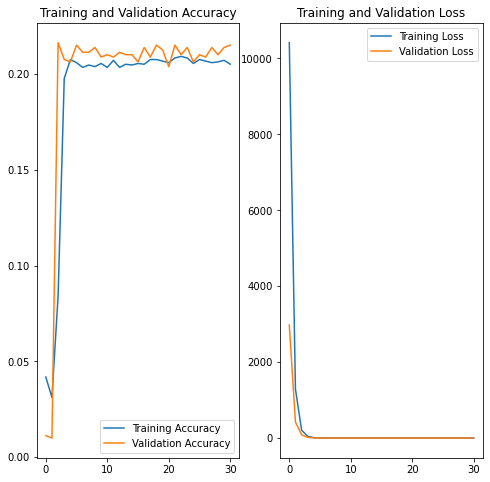

In [ ]:
number_of_epochs_it_ran = len(history_transfer_aug_drop.history['loss'])

acc = history_transfer_aug_drop.history['accuracy']
val_acc = history_transfer_aug_drop.history['val_accuracy']

loss = history_transfer_aug_drop.history['loss']
val_loss = history_transfer_aug_drop.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 9. Try VGG16  

In [ ]:
L2 = 50
DROP = 0.3

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "categorical",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

Found 3089 validated image filenames belonging to 10 classes.
Found 618 validated image filenames belonging to 10 classes.
Found 260 validated image filenames belonging to 10 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   

In [ ]:
model = Sequential(
                [InputLayer(input_shape= (img_height, img_width, 3)),
                 base_model,
                 Flatten(),
                 Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(L2)),
                 Dropout(DROP), 
                 Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(L2)),
                 Dropout(DROP), 
                 Dense(num_classes, activation='softmax')]
               )

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)

In [ ]:
lr = (ReduceLROnPlateau(factor=.5, patience=3, verbose=1))
es = (EarlyStopping(verbose=1, patience = 8, restore_best_weights=True, monitor='val_loss'))

In [ ]:
history_vgg_model = model.fit(train_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_generator,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=epochs,
                      callbacks = [es, lr])

Epoch 1/100
96/96 [==============================] - 133s 1s/step - loss: 2998.9644 - accuracy: 0.2421 - val_loss: 728.6398 - val_accuracy: 0.2747 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 125s 1s/step - loss: 295.0083 - accuracy: 0.2758 - val_loss: 70.6592 - val_accuracy: 0.2714 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 126s 1s/step - loss: 25.7334 - accuracy: 0.2787 - val_loss: 5.8879 - val_accuracy: 0.2697 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - 125s 1s/step - loss: 3.1496 - accuracy: 0.2820 - val_loss: 2.1181 - val_accuracy: 0.2730 - lr: 0.0010
Epoch 5/100
96/96 [==============================] - 125s 1s/step - loss: 2.0330 - accuracy: 0.2748 - val_loss: 1.9897 - val_accuracy: 0.2697 - lr: 0.0010
Epoch 6/100
96/96 [==============================] - 125s 1s/step - loss: 1.9908 - accuracy: 0.2774 - val_loss: 1.9914 - val_accuracy: 0.2730 - lr: 0.0010
Epoch 7/100
96/96 [==============================] - 126s 1s/

In [ ]:
model.save('vgg16_model_single_label.h5')

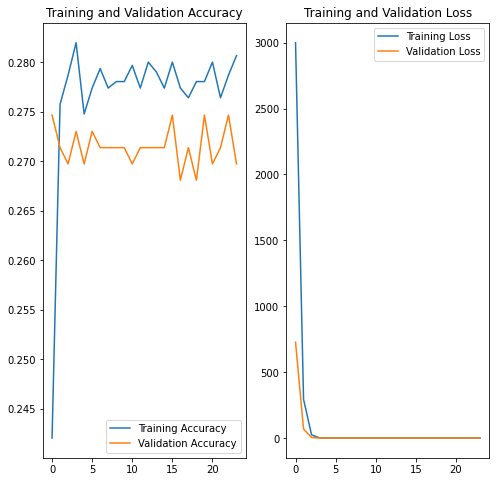

In [ ]:
number_of_epochs_it_ran = len(history_vgg_model.history['loss'])

acc = history_vgg_model.history['accuracy']
val_acc = history_vgg_model.history['val_accuracy']

loss = history_vgg_model.history['loss']
val_loss = history_vgg_model.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 10. VGG16 + CNN's

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "categorical",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            target_size = (img_height, img_width))

Found 3089 validated image filenames belonging to 10 classes.
Found 618 validated image filenames belonging to 10 classes.
Found 260 validated image filenames belonging to 10 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   

In [ ]:
x = base_model.output
x = Flatten()(x) 
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x) 
x = Dropout(DROP)(x)
x = Dense(200, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
x = Dense(300, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
x = Dense(300, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x) 
x = Dropout(DROP)(x)
predictions = Dense(num_classes, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
lr = (ReduceLROnPlateau(factor=.5, patience=3, verbose=1))
es = (EarlyStopping(verbose=1, patience = 8, restore_best_weights=True, monitor='val_loss'))
history_vgg_cnn_model = model.fit(train_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_generator,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=epochs,
                      callbacks = [es, lr])

Epoch 1/100
96/96 [==============================] - 123s 1s/step - loss: 13422.2715 - accuracy: 0.2650 - val_loss: 2162.1309 - val_accuracy: 0.2747 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 119s 1s/step - loss: 784.7031 - accuracy: 0.2800 - val_loss: 203.8680 - val_accuracy: 0.2714 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 119s 1s/step - loss: 93.4028 - accuracy: 0.2784 - val_loss: 32.6886 - val_accuracy: 0.2714 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - 121s 1s/step - loss: 15.7504 - accuracy: 0.2790 - val_loss: 6.2491 - val_accuracy: 0.2730 - lr: 0.0010
Epoch 5/100
96/96 [==============================] - 120s 1s/step - loss: 3.7625 - accuracy: 0.2787 - val_loss: 2.4492 - val_accuracy: 0.2714 - lr: 0.0010
Epoch 6/100
96/96 [==============================] - 119s 1s/step - loss: 2.1737 - accuracy: 0.2777 - val_loss: 2.0263 - val_accuracy: 0.2747 - lr: 0.0010
Epoch 7/100
96/96 [==============================] - 119

In [ ]:
model.save('vgg16_cnn_model_single_label.h5')

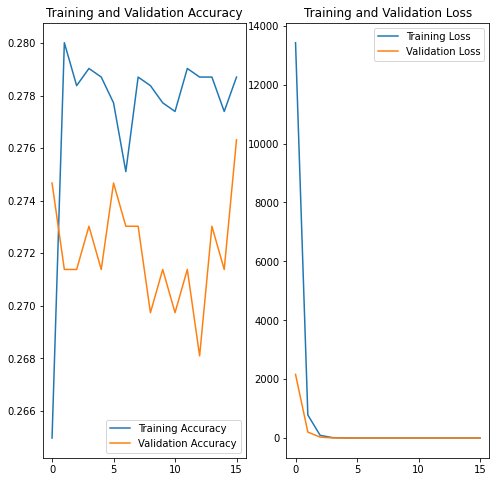

In [ ]:
number_of_epochs_it_ran = len(history_vgg_cnn_model.history['loss'])

acc = history_vgg_cnn_model.history['accuracy']
val_acc = history_vgg_cnn_model.history['val_accuracy']

loss = history_vgg_cnn_model.history['loss']
val_loss = history_vgg_cnn_model.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()